In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os 
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras.models import Sequential
import torch
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
import pandas as pd

In [2]:
img_dir = "/content/drive/MyDrive/So You Think You're Fit ?/vip/data"
img_height = 224 
img_width = 224
batch_size = 1026
input_shape = (img_height,img_width,3)

In [3]:
train = tf.keras.preprocessing.image_dataset_from_directory(
  img_dir,
  labels=None,
  label_mode=None,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1026 files belonging to 1 classes.


In [4]:
df = pd.read_csv("/content/drive/MyDrive/So You Think You're Fit ?/vip/annotation.csv")

In [5]:
df.head()

,image,height,weight,BMI
0,f_001,1.55,61.0,25.390219
1,f_002,1.76,85.0,27.440599
2,f_003,1.78,56.0,17.674536
3,f_004,1.63,63.0,23.711845
4,f_005,1.76,54.0,17.432851


In [6]:
y = df[['BMI']]

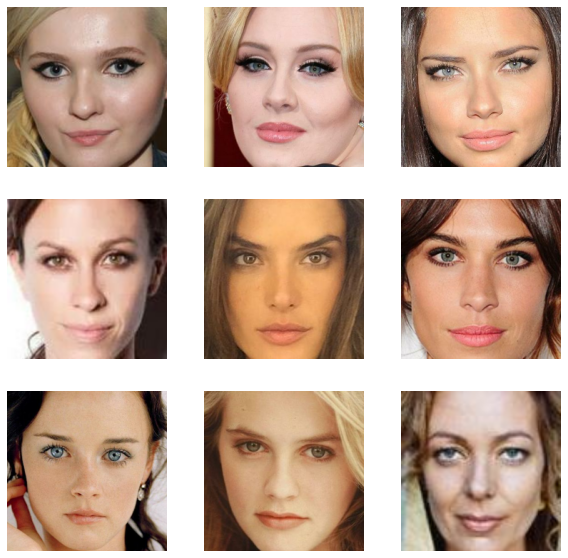

In [7]:
plt.figure(figsize=(10, 10))
for images in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(train_ds.class_names[labels[i][0].argmax()])
    plt.axis("off")

In [7]:
for im in train:
  X = im
  #break

In [8]:
X.shape

TensorShape([1026, 224, 224, 3])

In [9]:
 def train_test_splitt(X,y) :
   
   indices = tf.range(start=0, limit=X.shape[0], dtype=tf.int32)
   shuffled_indices = tf.random.shuffle(indices)

   shuffled_x = tf.gather(X, shuffled_indices)
   shuffled_y = tf.gather(y, shuffled_indices)

   return shuffled_x[:800],shuffled_x[800:],shuffled_y[:800],shuffled_y[800:]

In [10]:
X_train , X_test , y_train , y_test  = train_test_splitt(X,y)

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.3),
    #layers.CenterCrop(height = img_height, width = img_width),
    #layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [12]:
base_model = tf.keras.applications.densenet.DenseNet121(
    include_top=True, weights='imagenet',
    input_shape=input_shape 
)

33202176/33188688 [==============================] - 0s 0us/step


In [13]:
base_model.trainable = False
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [14]:
def get_cnn_model(input_shape, d = 0.2):
  model = Sequential()
  
  model.add(data_augmentation)
  model.add(layers.experimental.preprocessing.Rescaling(1./255))
  #conv
  
  model.add(base_model)
  
  #2 x FC
  model.add(Dense(512))
  #model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  model.add(Dense(128))
  #model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  model.add(Dense(1))

  #model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
  
  return model

In [16]:
model = get_cnn_model(input_shape) #, 0.4
#opt = keras.optimizers.adam(learning_rate=1e-3)#, decay = 0.95)
# model.compile(optimizer=opt,
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"), optimizer='adam', metrics=['mean_squared_error'])
history = model.fit(X_train, y_train, batch_size=32, epochs=50, 
                    validation_data=(X_test, y_test), verbose = 1)

Epoch 1/50
25/25 [==============================] - 47s 417ms/step - loss: 490.3904 - mean_squared_error: 490.3904 - val_loss: 330.5907 - val_mean_squared_error: 330.5907
Epoch 2/50
25/25 [==============================] - 7s 285ms/step - loss: 147.4428 - mean_squared_error: 147.4428 - val_loss: 18.2723 - val_mean_squared_error: 18.2723
Epoch 3/50
25/25 [==============================] - 7s 284ms/step - loss: 28.4887 - mean_squared_error: 28.4887 - val_loss: 12.4973 - val_mean_squared_error: 12.4973
Epoch 4/50
25/25 [==============================] - 7s 285ms/step - loss: 22.5942 - mean_squared_error: 22.5942 - val_loss: 11.0915 - val_mean_squared_error: 11.0915
Epoch 5/50
25/25 [==============================] - 7s 283ms/step - loss: 19.6977 - mean_squared_error: 19.6977 - val_loss: 9.7600 - val_mean_squared_error: 9.7600
Epoch 6/50
25/25 [==============================] - 7s 284ms/step - loss: 19.9392 - mean_squared_error: 19.9392 - val_loss: 9.6129 - val_mean_squared_error: 9.6129
E

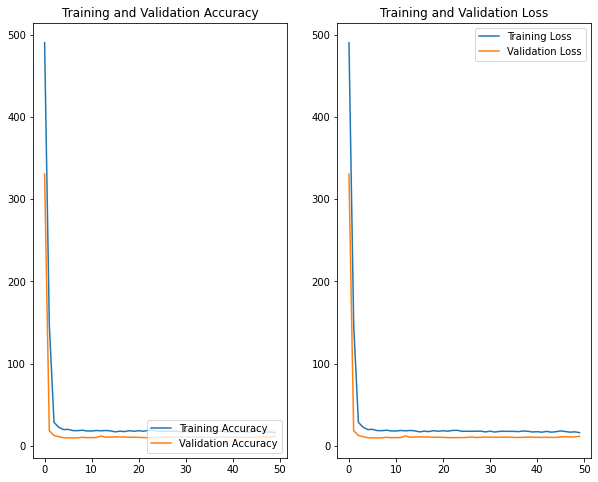

In [17]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 1000)              8062504   
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)              

In [21]:
model.save("/content/drive/MyDrive/So You Think You're Fit ?/model.h5")

In [28]:
model = keras.models.load_model("/content/drive/MyDrive/So You Think You're Fit ?/model.h5")

In [29]:
p = np.asarray(X_test[1])

In [30]:
p = p.reshape(1,224,224,3)

In [31]:
model.predict(p)

array([[23.207249]], dtype=float32)

In [32]:
y_test[1]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([18.33910035])>

In [26]:
model.save_weights("/content/drive/MyDrive/So You Think You're Fit ?/model_weights/")
#load_status = model.load_weights("/content/drive/MyDrive/So You Think You're Fit ?/model_weights")

Facial Feature

In [71]:
!tar -xzvf "/content/drive/MyDrive/So You Think You're Fit ?/UTKFace.tar.gz" -C "/content/drive/MyDrive/So You Think You're Fit ?/UTKFace"

Streaming output truncated to the last 5000 lines.
UTKFace/33_1_0_20170111182452825.jpg.chip.jpg
UTKFace/26_1_1_20170116024053194.jpg.chip.jpg
UTKFace/25_1_0_20170109213232182.jpg.chip.jpg
UTKFace/28_1_1_20170112234526480.jpg.chip.jpg
UTKFace/57_0_0_20170117191704100.jpg.chip.jpg
UTKFace/27_1_1_20170117193211345.jpg.chip.jpg
UTKFace/46_1_1_20170116161237892.jpg.chip.jpg
UTKFace/24_0_2_20170116171647508.jpg.chip.jpg
UTKFace/42_1_1_20170113005712902.jpg.chip.jpg
UTKFace/25_1_1_20170116001337504.jpg.chip.jpg
UTKFace/40_1_0_20170116222110661.jpg.chip.jpg
UTKFace/50_1_0_20170109012257664.jpg.chip.jpg
UTKFace/26_1_3_20170104235421282.jpg.chip.jpg
UTKFace/7_0_0_20170110215711115.jpg.chip.jpg
UTKFace/1_1_2_20161219155353413.jpg.chip.jpg
UTKFace/26_0_1_20170117195651493.jpg.chip.jpg
UTKFace/7_0_0_20170110215648859.jpg.chip.jpg
UTKFace/64_0_0_20170117155540137.jpg.chip.jpg
UTKFace/48_0_0_20170109004813150.jpg.chip.jpg
UTKFace/39_0_0_20170103183230555.jpg.chip.jpg
UTKFace/45_0_1_20170117190019363

In [15]:
img_dir = "/content/drive/MyDrive/So You Think You're Fit ?/UTKFace"
img_height = 224 
img_width = 224
batch_size = 32
input_shape = (img_height,img_width,3)

In [26]:
trainf = tf.keras.preprocessing.image_dataset_from_directory(
  img_dir,
  labels=None,
  label_mode=None,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=2000)

Found 23708 files belonging to 1 classes.


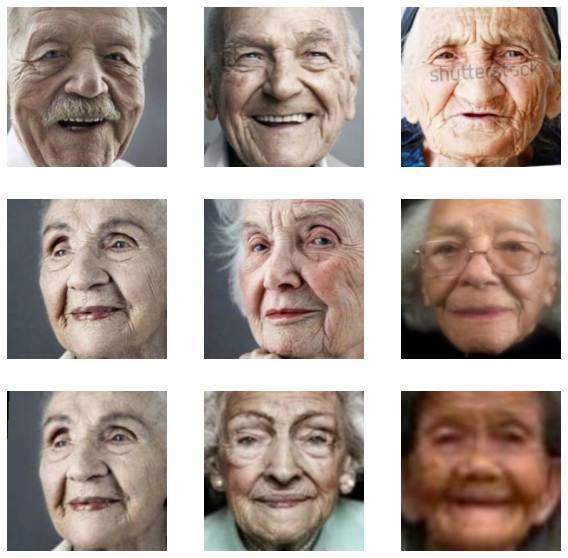

In [54]:
plt.figure(figsize=(10, 10))
for images in trainf.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(train_ds.class_names[labels[i][0].argmax()])
    plt.axis("off")

In [28]:
yf = []
i=0
for (root,dirs,files) in os.walk("/content/drive/MyDrive/So You Think You're Fit ?/UTKFace"):
  for im in files:
    if i == 2000:
      break
    i+=1
    yf.append(int(im.split("_")[0]))
        

In [42]:
len(yf)

2000

In [30]:
for im in trainf:
  Xf = im
  break

In [31]:
def train_test_splitt2(X,y) :
   
   indices = tf.range(start=0, limit=X.shape[0], dtype=tf.int32)
   shuffled_indices = tf.random.shuffle(indices)

   shuffled_x = tf.gather(X, shuffled_indices)
   shuffled_y = tf.gather(y, shuffled_indices)

   return shuffled_x[:1700],shuffled_x[1700:],shuffled_y[:1700],shuffled_y[1700:]

In [32]:
X_trainf , X_testf , y_trainf , y_testf  = train_test_splitt2(Xf,yf)

In [35]:
X_testf.shape

TensorShape([300, 224, 224, 3])

In [41]:
base_model2 = tf.keras.applications.resnet.ResNet101(
    include_top=True, weights='imagenet',
    input_shape=input_shape
)

179658752/179648224 [==============================] - 2s 0us/step


In [43]:
base_model2.trainable = False
base_model2.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [36]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.3),
    #layers.CenterCrop(height = img_height, width = img_width),
    #layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [47]:
def get_cnn_model2(input_shape, d = 0.2):
  model = Sequential()
  
  model.add(data_augmentation)
  model.add(layers.experimental.preprocessing.Rescaling(1./255))
  #conv
  
  model.add(base_model2)
  
  #2 x FC
  model.add(Dense(1024))
  
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  model.add(Dense(512))
  
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  model.add(Dense(128))

  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  model.add(Dense(64))
  
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  model.add(Dense(1))

  #model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
  
  return model

In [49]:
model2 = get_cnn_model2(input_shape) #, 0.4
#opt = keras.optimizers.adam(learning_rate=1e-3)#, decay = 0.95)
# model.compile(optimizer=opt,
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model2.compile(loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"), optimizer='adam', metrics=['mean_squared_error'])
history = model2.fit(X_testf,y_testf, batch_size=32, epochs=50, 
                    validation_data=(X_trainf,y_trainf), verbose = 1)

Epoch 1/50
10/10 [==============================] - 33s 3s/step - loss: 2727.7407 - mean_squared_error: 2727.7407 - val_loss: 2432.6160 - val_mean_squared_error: 2432.6160
Epoch 2/50
10/10 [==============================] - 23s 2s/step - loss: 1998.2904 - mean_squared_error: 1998.2904 - val_loss: 744.3081 - val_mean_squared_error: 744.3081
Epoch 3/50
10/10 [==============================] - 23s 2s/step - loss: 538.9561 - mean_squared_error: 538.9561 - val_loss: 355.8212 - val_mean_squared_error: 355.8212
Epoch 4/50
10/10 [==============================] - 23s 2s/step - loss: 394.5251 - mean_squared_error: 394.5251 - val_loss: 392.9769 - val_mean_squared_error: 392.9769
Epoch 5/50
10/10 [==============================] - 23s 2s/step - loss: 331.4347 - mean_squared_error: 331.4347 - val_loss: 296.7131 - val_mean_squared_error: 296.7131
Epoch 6/50
10/10 [==============================] - 23s 2s/step - loss: 297.2994 - mean_squared_error: 297.2994 - val_loss: 261.8570 - val_mean_squared_er

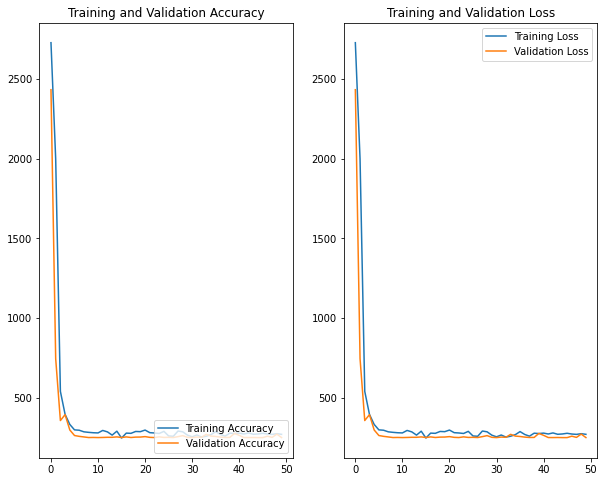

In [50]:
acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
model2.save("/content/drive/MyDrive/So You Think You're Fit ?/model2.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [53]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet101 (Functional)      (None, 1000)              44707176  
                                                                 
 dense_7 (Dense)             (None, 1024)              1025024   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)              